# Авиарейсы без потерь

#### Задача:
Выяснить, от каких самых малоприбыльных рейсов из Анапы возможно отказаться в зимнее время.Критерии, по которым будет происходить отбор рейсов не известен. В контексте проекта, **прибыльность рейса** - разница между доходом от продаж билетов и расходом на полет.
В проекте будет использоваться упрощенная модель оценки прибыльности: **стоимость билетов - стоимость топлива на рейс** (для оценки последнего будет использоваться длительность рейса).

В данном проекте используются данные за декабрь 2016 - февраль 2017.

In [180]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind
import numpy as np

pd.set_option('display.max_rows', 50)  # increase number of rows displayed
pd.set_option('display.max_columns', 50)  # increase number of cols displayed

In [181]:
ds = pd.read_csv('query_data.csv')

display(ds.sample(5))
ds.info()

,flight_id,flight_no,departure_airport,arrival_airport,flight_length_min,flight_departure_date,flight_departure_time,flight_departure_weekday,flight_ticket_count,flight_ticket_sold_total,aircraft_model,aircraft_seat_count,aircraft_code
28,136250,PG0252,AAQ,SVO,100.0,2017-02-08,10:05,4,99.0,1407800.0,Boeing 737-300,130,733
75,136441,PG0252,AAQ,SVO,100.0,2017-02-03,10:05,6,128.0,1837200.0,Boeing 737-300,130,733
64,136390,PG0252,AAQ,SVO,100.0,2016-12-26,10:05,2,125.0,1823800.0,Boeing 737-300,130,733
135,136729,PG0480,AAQ,EGO,50.0,2017-01-29,09:25,1,88.0,695400.0,Sukhoi Superjet-100,97,SU9
3,136130,PG0252,AAQ,SVO,100.0,2017-02-13,10:05,2,107.0,1556600.0,Boeing 737-300,130,733


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193 entries, 0 to 192
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   flight_id                 193 non-null    int64  
 1   flight_no                 193 non-null    object 
 2   departure_airport         193 non-null    object 
 3   arrival_airport           193 non-null    object 
 4   flight_length_min         193 non-null    float64
 5   flight_departure_date     193 non-null    object 
 6   flight_departure_time     193 non-null    object 
 7   flight_departure_weekday  193 non-null    int64  
 8   flight_ticket_count       180 non-null    float64
 9   flight_ticket_sold_total  180 non-null    float64
 10  aircraft_model            193 non-null    object 
 11  aircraft_seat_count       193 non-null    int64  
 12  aircraft_code             193 non-null    object 
dtypes: float64(3), int64(3), object(7)
memory usage: 19.7+ KB


## Описание данных датасета
* flight_id - идентификатор рейса
* flight_no - номер рейса
* departure_airport - аэропорт вылета
* arrival_airport - аэропорт прилета
* flight_length_min - продолжительность полета в минутах (по графику)
* flight_departure_date - дата вылета (по графику)
* flight_departure_time - время вылета (по графику)
* flight_departure_weekday - день недели вылета (по графику)
* flight_ticket_count - количество проданных билетов
* flight_ticket_sold_total - стоимость всех проданных билетов
* aircraft_model - модель самолета
* aircraft_seat_count - количество мест в самолете
* aircraft_code - код самолета

## Подготовка данных
В датасете присутствуют NaN значения: flight_ticket_count и flight_ticket_sold_total:

In [182]:
for c in ['flight_ticket_count', 'flight_ticket_sold_total']:
    print(f'Количество пропущенных значений {c}:',
          ds[c].isna().sum())

Количество пропущенных значений flight_ticket_count: 13
Количество пропущенных значений flight_ticket_sold_total: 13


Видимо, рейсы выполнялись без пассажиров. Посмотрим на номера рейсов.

In [183]:
display(ds[ds.flight_ticket_count.isna()])

,flight_id,flight_no,departure_airport,arrival_airport,flight_length_min,flight_departure_date,flight_departure_time,flight_departure_weekday,flight_ticket_count,flight_ticket_sold_total,aircraft_model,aircraft_seat_count,aircraft_code
90,136511,PG0194,AAQ,NOZ,305.0,2017-02-21,06:10,3,NaN,NaN,Boeing 737-300,130,733
91,136513,PG0194,AAQ,NOZ,305.0,2017-02-28,06:10,3,NaN,NaN,Boeing 737-300,130,733
92,136514,PG0194,AAQ,NOZ,305.0,2017-02-07,06:10,3,NaN,NaN,Boeing 737-300,130,733
93,136518,PG0194,AAQ,NOZ,305.0,2016-12-20,06:10,3,NaN,NaN,Boeing 737-300,130,733
94,136523,PG0194,AAQ,NOZ,305.0,2017-01-10,06:10,3,NaN,NaN,Boeing 737-300,130,733
95,136533,PG0194,AAQ,NOZ,305.0,2016-12-13,06:10,3,NaN,NaN,Boeing 737-300,130,733
96,136534,PG0194,AAQ,NOZ,305.0,2016-12-06,06:10,3,NaN,NaN,Boeing 737-300,130,733
97,136540,PG0194,AAQ,NOZ,305.0,2017-01-17,06:10,3,NaN,NaN,Boeing 737-300,130,733
98,136544,PG0194,AAQ,NOZ,305.0,2017-01-31,06:10,3,NaN,NaN,Boeing 737-300,130,733
99,136546,PG0194,AAQ,NOZ,305.0,2017-01-03,06:10,3,NaN,NaN,Boeing 737-300,130,733


In [184]:
ds[(ds.flight_ticket_count.notna())].flight_no.unique()

array(['PG0252', 'PG0480'], dtype=object)

Все записи по рейсу `PG0194` не содержат информации о проданных билетах. Возможно, это почтовый рейс? В любом случае для нашей задачи по данному рейсу мы не располагаем достаточной информацией для того, чтобы делать выводы - эти данные учитываться не будут.
Таким образом, в нашем датасете мы будем расссматривать только два рейса: `PG0252` и `PG0480`.

In [185]:
ds.dropna(axis=0, inplace=True)


Для удобства, используем PeriodIndex для даты вылета:

In [186]:
ds['flight_departure_mon'] = pd.to_datetime(ds.flight_departure_date).dt.to_period("M")
ds.drop(columns='flight_departure_date', inplace=True)

Полезно было бы иметь признак коэффициента заполняемости мест.

In [187]:
ds["flight_ticket_sold_coef"] = ds.flight_ticket_count / ds.aircraft_seat_count
display(ds.sample(5))

,flight_id,flight_no,departure_airport,arrival_airport,flight_length_min,flight_departure_time,flight_departure_weekday,flight_ticket_count,flight_ticket_sold_total,aircraft_model,aircraft_seat_count,aircraft_code,flight_departure_mon,flight_ticket_sold_coef
174,136873,PG0480,AAQ,EGO,50.0,09:25,7,96.0,759000.0,Sukhoi Superjet-100,97,SU9,2016-12,0.989691
163,136841,PG0480,AAQ,EGO,50.0,09:25,3,97.0,765300.0,Sukhoi Superjet-100,97,SU9,2017-02,1.000000
35,136268,PG0252,AAQ,SVO,100.0,10:05,5,115.0,1676200.0,Boeing 737-300,130,733,2017-02,0.884615
136,136733,PG0480,AAQ,EGO,50.0,09:25,2,94.0,746400.0,Sukhoi Superjet-100,97,SU9,2017-01,0.969072
49,136322,PG0252,AAQ,SVO,100.0,10:05,2,108.0,1567600.0,Boeing 737-300,130,733,2017-02,0.830769


### Внешние данные
Очевидно, для возможности подсчета расходов на выполнение рейса даже в контексте упрощенной модели нам понадобятся данные о расходе топлива для каждой модели самолета, цена топлива (например, по месяцам). Такого типа данные в нашем датасете отсутствуют.

Сначала посмотрим, какие модели самолетов попали в датасет:

In [188]:
pd.DataFrame(ds.aircraft_model.value_counts())

,aircraft_model
Boeing 737-300,90
Sukhoi Superjet-100,90


Используем следующие источники: 
* https://favt.gov.ru/dejatelnost-ajeroporty-i-ajerodromy-ceny-na-aviagsm/
* http://superjet.wikidot.com/wiki:rashod-topliva
* https://www.airlines-inform.ru/commercial-aircraft/boeing-737-300.html

Датасет включает следующие данные:
* aircraft_model - модель самолета
* fuel_consumption - расход топлива кг/ч
* fuel_price_201612 - цена топлива дек. 2016 руб/т
* fuel_price_201701 - цена топлива янв. 2017 руб/т
* fuel_price_201702 - цена топлива фев. 2017 руб/т

In [189]:
fuel_ds = pd.read_csv('fuel_data.csv')
display(fuel_ds)

,aircraft_model,fuel_consumption,fuel_price_201612,fuel_price_201701,fuel_price_201702
0,Boeing 737-300,2600,38867,41435,39553
1,Sukhoi Superjet-100,1700,38867,41435,39553


In [190]:
def get_fuel_cost(r):
    '''
    Returns fuel cost for given dataset row
    '''
    # Convert flight length from minutes to hours
    flen_hr = r.flight_length_min / 60
    # Get amount of consumed fuel in tonnes
    fuel_tonnes = (flen_hr * r.fuel_consumption) / 1000
    # Calculate cost of fuel per flight
    if r.flight_departure_mon.year == 2016:
        if r.flight_departure_mon.month == 12:
            return round(r.fuel_price_201612 * fuel_tonnes, 0)
    elif r.flight_departure_mon.year == 2017:
        if r.flight_departure_mon.month == 1:
            return round(r.fuel_price_201701 * fuel_tonnes, 0)
        elif r.flight_departure_mon.month == 2:
            return round(r.fuel_price_201702 * fuel_tonnes, 0)  
    return 0
    
    
ds = pd.merge(ds, fuel_ds, on='aircraft_model', how='left')
ds['fuel_cost'] = ds.apply(get_fuel_cost, axis=1)
ds.drop(columns=['fuel_price_201612', 'fuel_price_201701', 
                 'fuel_price_201702'],
        inplace=True)
display(ds.sample(5))

,flight_id,flight_no,departure_airport,arrival_airport,flight_length_min,flight_departure_time,flight_departure_weekday,flight_ticket_count,flight_ticket_sold_total,aircraft_model,aircraft_seat_count,aircraft_code,flight_departure_mon,flight_ticket_sold_coef,fuel_consumption,fuel_cost
50,136324,PG0252,AAQ,SVO,100.0,10:05,2,118.0,1666400.0,Boeing 737-300,130,733,2016-12,0.907692,2600,168424.0
147,136823,PG0480,AAQ,EGO,50.0,09:25,1,78.0,620400.0,Sukhoi Superjet-100,97,SU9,2017-02,0.804124,1700,56033.0
152,136844,PG0480,AAQ,EGO,50.0,09:25,3,79.0,575100.0,Sukhoi Superjet-100,97,SU9,2017-02,0.814433,1700,56033.0
175,136943,PG0480,AAQ,EGO,50.0,09:25,2,94.0,733800.0,Sukhoi Superjet-100,97,SU9,2016-12,0.969072,1700,55062.0
28,136250,PG0252,AAQ,SVO,100.0,10:05,4,99.0,1407800.0,Boeing 737-300,130,733,2017-02,0.761538,2600,171396.0


Исходя из структуры затрат российских авиакомпаний можно получить приблизительное значение расходов на осуществление рейса, имея стоимость топлива, что, согласно, наример, https://www.aex.ru/docs/2/2018/10/11/2818/ является примерно 23% от общих затрат:
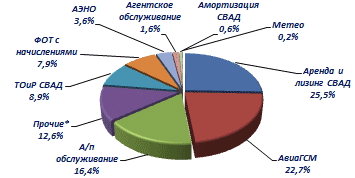

In [191]:
ds['flight_cost'] = round(ds.fuel_cost * 100 / 23, 0)
display(ds.sample(5))

,flight_id,flight_no,departure_airport,arrival_airport,flight_length_min,flight_departure_time,flight_departure_weekday,flight_ticket_count,flight_ticket_sold_total,aircraft_model,aircraft_seat_count,aircraft_code,flight_departure_mon,flight_ticket_sold_coef,fuel_consumption,fuel_cost,flight_cost
97,136617,PG0480,AAQ,EGO,50.0,09:25,3,97.0,765300.0,Sukhoi Superjet-100,97,SU9,2016-12,1.000000,1700,55062.0,239400.0
48,136320,PG0252,AAQ,SVO,100.0,10:05,1,106.0,1544400.0,Boeing 737-300,130,733,2017-02,0.815385,2600,171396.0,745200.0
71,136423,PG0252,AAQ,SVO,100.0,10:05,3,129.0,1849400.0,Boeing 737-300,130,733,2017-01,0.992308,2600,179552.0,780661.0
26,136244,PG0252,AAQ,SVO,100.0,10:05,5,117.0,1703000.0,Boeing 737-300,130,733,2016-12,0.900000,2600,168424.0,732278.0
135,136778,PG0480,AAQ,EGO,50.0,09:25,4,96.0,759000.0,Sukhoi Superjet-100,97,SU9,2017-02,0.989691,1700,56033.0,243622.0


In [192]:
ds['flight_revenue'] = ds.flight_ticket_sold_total - ds.flight_cost
display(ds.sample(5))

,flight_id,flight_no,departure_airport,arrival_airport,flight_length_min,flight_departure_time,flight_departure_weekday,flight_ticket_count,flight_ticket_sold_total,aircraft_model,aircraft_seat_count,aircraft_code,flight_departure_mon,flight_ticket_sold_coef,fuel_consumption,fuel_cost,flight_cost,flight_revenue
5,136132,PG0252,AAQ,SVO,100.0,10:05,4,116.0,1714000.0,Boeing 737-300,130,733,2017-02,0.892308,2600,171396.0,745200.0,968800.0
127,136755,PG0480,AAQ,EGO,50.0,09:25,7,97.0,765300.0,Sukhoi Superjet-100,97,SU9,2017-01,1.000000,1700,58700.0,255217.0,510083.0
45,136310,PG0252,AAQ,SVO,100.0,10:05,1,117.0,1654200.0,Boeing 737-300,130,733,2017-01,0.900000,2600,179552.0,780661.0,873539.0
2,136122,PG0252,AAQ,SVO,100.0,10:05,1,97.0,1431000.0,Boeing 737-300,130,733,2017-01,0.746154,2600,179552.0,780661.0,650339.0
91,136586,PG0480,AAQ,EGO,50.0,09:25,3,96.0,759000.0,Sukhoi Superjet-100,97,SU9,2017-01,0.989691,1700,58700.0,255217.0,503783.0


In [193]:
ds.describe()

,flight_id,flight_length_min,flight_departure_weekday,flight_ticket_count,flight_ticket_sold_total,aircraft_seat_count,flight_ticket_sold_coef,fuel_consumption,fuel_cost,flight_cost,flight_revenue
count,180.000000,180.000000,180.00000,180.000000,1.800000e+02,180.000000,180.000000,180.000000,180.000000,180.000000,1.800000e+02
mean,136540.794444,75.000000,4.00000,101.950000,1.179647e+06,113.500000,0.902591,2150.000000,114899.388889,499562.511111,6.800847e+05
std,258.233139,25.069735,2.01669,14.423086,4.811836e+05,16.546025,0.081175,451.255233,58553.080121,254578.616887,2.412023e+05
min,136119.000000,50.000000,1.00000,64.000000,5.310000e+05,97.000000,0.659794,1700.000000,55062.000000,239400.000000,2.757830e+05
25%,136309.000000,50.000000,2.00000,93.000000,7.385250e+05,97.000000,0.838462,1700.000000,56033.000000,243622.000000,4.944000e+05
50%,136531.500000,75.000000,4.00000,97.000000,1.068850e+06,113.500000,0.907216,2150.000000,113562.000000,493747.500000,5.716195e+05
75%,136775.000000,100.000000,6.00000,112.250000,1.631950e+06,130.000000,0.989691,2600.000000,171396.000000,745200.000000,8.760042e+05
max,136961.000000,100.000000,7.00000,130.000000,1.886000e+06,130.000000,1.000000,2600.000000,179552.000000,780661.000000,1.153722e+06


#### Коэффициент заполняемости
Коэффициент заполняемости может быть одним из основных индикаторов окупаемости/прибыльности рейса.

Text(0.5, 1.0, 'Заполняемость рейсов')

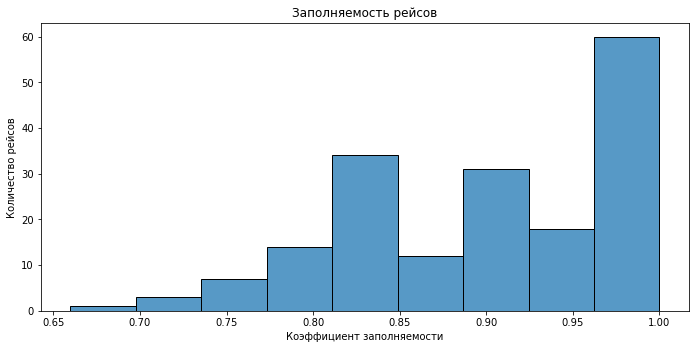

In [194]:
fig = plt.figure()
axes = fig.add_axes([0, 0, 1.5, 1])
sns.histplot(data=ds, x='flight_ticket_sold_coef')
axes.set_xlabel('Коэффициент заполняемости')
axes.set_ylabel('Количество рейсов')
axes.set_title('Заполняемость рейсов')

#### Прибыль по рейсам за период

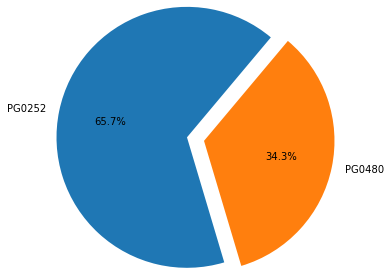

In [195]:
labels = list(ds.groupby('flight_no')['flight_revenue'].sum().index)
sizes = ds.groupby('flight_no')['flight_revenue'].sum()
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=(0.1, 0.1), labels=labels, autopct='%1.1f%%',
        startangle=50, radius=1.5)
plt.show()

In [196]:
def show_values_on_bars(axs, y_pos_mul):
    '''
    Выводит значения на seaborn barplots
    https://stackoverflow.com/questions/43214978/seaborn-barplot-displaying-values
    '''
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height() * y_pos_mul
            value = '{:.2f}'.format(p.get_height())
            ax.text(_x, _y, value, ha="center") 

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)
        

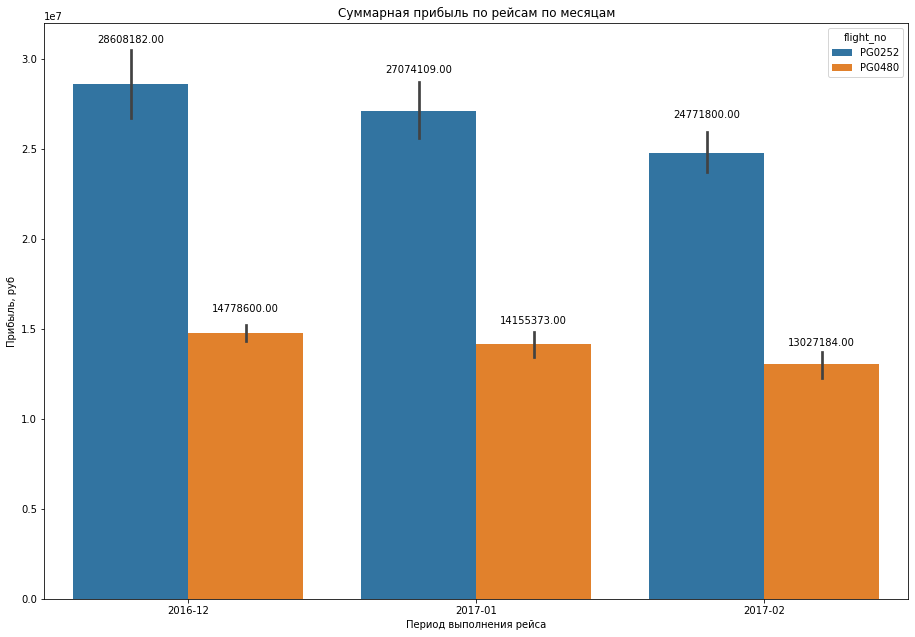

In [197]:
fig = plt.figure()
axes = fig.add_axes([0, 0, 2, 2])
sns.barplot(x='flight_departure_mon', y='flight_revenue', hue='flight_no',
            data=ds.sort_values(by=['flight_departure_mon']), estimator=sum)
axes.set_xlabel('Период выполнения рейса')
axes.set_ylabel('Прибыль, руб')
axes.set_title('Суммарная прибыль по рейсам по месяцам')
show_values_on_bars(axes, 1.08)

### Заполняемость рейсов за период

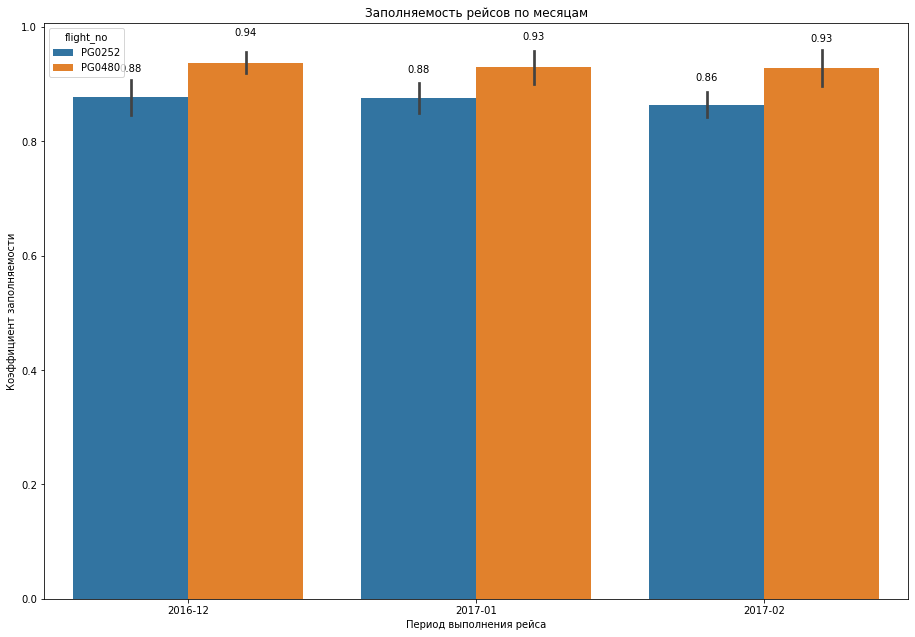

In [198]:
fig = plt.figure()
axes = fig.add_axes([0, 0, 2, 2])
sns.barplot(x='flight_departure_mon', y='flight_ticket_sold_coef', hue='flight_no',
            data=ds.sort_values(by=['flight_departure_mon']))
axes.set_xlabel('Период выполнения рейса')
axes.set_ylabel('Коэффициент заполняемости')
axes.set_title('Заполняемость рейсов по месяцам')
show_values_on_bars(axes, 1.05)